In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_curve, auc

from Bio.Align import substitution_matrices

AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')

BLOSUM62 = substitution_matrices.load('BLOSUM62')

SOFTMAX_BLOSUM62 = np.exp(BLOSUM62) / np.exp(BLOSUM62).sum(axis=1)[:, None]

BLOSUM62_DICT = {aa1: {aa2: BLOSUM62[aa1, aa2] for aa2 in AMINO_ACIDS} for aa1 in AMINO_ACIDS}

SOFTMAX_BLOSUM62_DICT = {aa1: {aa2: SOFTMAX_BLOSUM62[aa1, aa2] for aa2 in AMINO_ACIDS} for aa1 in AMINO_ACIDS}


WT_SEQ = 'HPVGEADYFEY'

df_orig = pd.read_csv('hpvg_and_hpvg_q5_peptide_designs_with_hcnn__pae_cutoff=5.1__seed=43.csv')

df_orig

FileNotFoundError: [Errno 2] No such file or directory: 'hpvg_and_hpvg_q5_peptide_designs_with_hcnn__pae_cutoff=5.1__seed=43.csv'

In [2]:
## compute the AF3 PAE score in the same way that Phil does (I think?) in his TCRdock code
## also put column with ranking score to see how those correlate, as a baseline
## take the best-ranked structure out of the 5 that get returned

## unzip everything
for filename in os.listdir('alphafold3'):
    if not os.path.exists(f'alphafold3/{filename[:-4]}'):
        if filename.endswith('.zip'):
            os.makedirs(f'alphafold3/{filename[:-4]}')
            os.system(f'unzip alphafold3/{filename} -d alphafold3/{filename[:-4]}')

def get_ranking_score(json_dict):
    return json_dict['ranking_score']

def get_tcr_pmhc_pae_score(json_dict, sequence):

    ## adapted from Phil's TCRdock code
    
    cs = ['GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQR',
          sequence,
          'QVTQSPEALRLQEGESSSLNCSYTVSGLRGLFWYRQDPGKGPEFLFTLYSAGEEKEKERLKATLTKKESFLHITAPKPEDSATYLCAVQDLGTSGSRLTFGEGTQLTVNPN',
          'DSGVTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFLIQYYNGEERAKGNILERFSAQQFPDLHSELNLSSLELGDSALYFCASSARSGELFFGEGSRLTVLED']

    num_chains = len(cs)
    assert num_chains in [4,5] # mhc class 1 or 2

    pmhc_chains = range(num_chains-2)
    tcr_chains = range(num_chains-2, num_chains)

    inter_pae = 0.
    pairs = []
    for i in pmhc_chains:
        nres_i = len(cs[i])
        for j in tcr_chains:
            nres_j = len(cs[j])
            pae_ij = json_dict['chain_pair_pae_min'][i][j]
            pae_ji = json_dict['chain_pair_pae_min'][j][i]
            inter_pae += nres_i * nres_j * (pae_ij + pae_ji)
            pairs.append((i,j))
    nres_pmhc = sum(len(cs[x]) for x in pmhc_chains)
    nres_tcr = sum(len(cs[x]) for x in tcr_chains)
    inter_pae /= 2*nres_pmhc*nres_tcr

    return inter_pae


import json

system = 'ebv'

af3_tcr_pmhc_pae_scores = []
af3_ranking_scores = []
for sequence in df_orig['sequence']:
    if type(sequence) == str:
        if os.path.exists(f'alphafold3/fold_{system}_{sequence.lower()}_1/'):
            temp_ranking_scores = []
            temp_pae_scores = []
            for i in range(5):
                with open(f'alphafold3/fold_{system}_{sequence.lower()}_1/fold_{system}_{sequence.lower()}_1_summary_confidences_{i}.json') as f:
                    summary_confidences = json.load(f)
                temp_ranking_scores.append(get_ranking_score(summary_confidences))
                temp_pae_scores.append(get_tcr_pmhc_pae_score(summary_confidences, sequence))
            
            # select best based on ranking score
            best_i = np.argmin(temp_pae_scores)
            af3_tcr_pmhc_pae_scores.append(temp_pae_scores[best_i])
            af3_ranking_scores.append(temp_ranking_scores[best_i])
        else:
            af3_tcr_pmhc_pae_scores.append(np.nan)
            af3_ranking_scores.append(np.nan)
    else:
        af3_tcr_pmhc_pae_scores.append(np.nan)
        af3_ranking_scores.append(np.nan)

df_orig['af3_tcr_pmhc_pae_score'] = af3_tcr_pmhc_pae_scores
df_orig['af3_ranking_scores'] = af3_ranking_scores


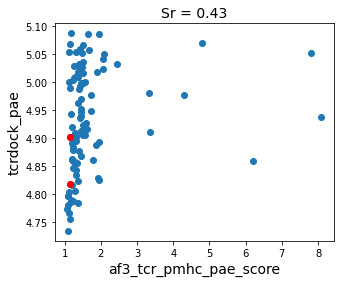

['MPFGRATYFDY' 'FPLGRGDYHLF' 'FPYGRATYWQY' 'YPLPLYDFWYY' 'YPYGFYDYILY'
 'FPFGFYDYIRY' 'YPLGRGDFWLY' 'FPYGYRDDVGM' 'FPYGRQEYWQF' 'MPFGRADFWEF'
 'FPYGRANYWVY']


In [3]:
plt.figure(figsize=(5, 4))
plt.scatter(df_orig['af3_tcr_pmhc_pae_score'], df_orig['tcrdock_pae'])

mask = df_orig['sequence'].apply(lambda x: x in {'HPVGEADYFEY', 'HPVGQADYFEY'})
plt.scatter(df_orig['af3_tcr_pmhc_pae_score'][mask], df_orig['tcrdock_pae'][mask], color='red')

plt.xlabel('af3_tcr_pmhc_pae_score', fontsize=14)
plt.ylabel('tcrdock_pae', fontsize=14)
plt.title(f'Sr = {spearmanr(df_orig["af3_tcr_pmhc_pae_score"], df_orig["tcrdock_pae"])[0]:.2f}', fontsize=14)
plt.show()

# select peptide sequences with score higher than 2, exclude them!
mask = df_orig['af3_tcr_pmhc_pae_score'] > 2
bad_sequences = df_orig[mask]['sequence'].values

print(bad_sequences)

df_filtered = df_orig[~mask]

df_filtered.to_csv('hpvg_and_hpvg_q5_peptide_designs_with_hcnn__pae_cutoff=5.1__seed=43__filtered_by_AF3.csv')



In [4]:
## analyze the sequences that I re-sampled to replenish what AF3 said wasn't gonna work

df_new = pd.read_csv('hpvg_and_hpvg_q5_peptide_designs_with_hcnn__pae_cutoff=5.1__seed=43__EXTRA_FOR_AF3_TESTING.csv')

df_new

,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_hpvg,hamming_distance_from_hpvg_q5
0,YPVGQANFWEF,so3_convnet_base_ensemble,fixed_structure,hpvg,4.969626,6,5
1,YPFGLGAYEPY,so3_convnet_noise=0p5,fixed_structure,hpvg,4.837315,7,7
2,FPFGRGDFWEY,so3_convnet_noise=0p5,fixed_structure,hpvg,4.876001,6,6
3,FPCGFADFWNY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.946532,6,6
4,HPIGQGDFWEF,so3_convnet_base_ensemble,fixed_structure,hpvg,4.772525,6,5
5,EPVGEADFWEF,so3_convnet_base_ensemble,fixed_structure,hpvg,4.957910,4,5
6,MPLGYSDYWVY,so3_convnet_noise=0p5,fixed_structure,hpvg,4.805569,6,6
7,YPLGRADFWEF,so3_convnet_noise=0p5,fixed_structure,hpvg,4.873115,6,6
8,HPVGEADFWRY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.960571,3,4
9,MPLGEADFWEY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.883311,4,5


In [5]:
## compute the AF3 PAE score in the same way that Phil does (I think?) in his TCRdock code
## also put column with ranking score to see how those correlate, as a baseline
## take the best-ranked structure out of the 5 that get returned

## unzip everything
for filename in os.listdir('alphafold3'):
    if not os.path.exists(f'alphafold3/{filename[:-4]}'):
        if filename.endswith('.zip'):
            os.makedirs(f'alphafold3/{filename[:-4]}')
            os.system(f'unzip alphafold3/{filename} -d alphafold3/{filename[:-4]}')

def get_ranking_score(json_dict):
    return json_dict['ranking_score']

def get_tcr_pmhc_pae_score(json_dict, sequence):

    ## adapted from Phil's TCRdock code
    
    cs = ['GSHSMRYFYTAMSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDRNTQIFKTNTQTYRESLRNLRGYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRAYLEGLCVEWLRRYLENGKETLQR',
          sequence,
          'QVTQSPEALRLQEGESSSLNCSYTVSGLRGLFWYRQDPGKGPEFLFTLYSAGEEKEKERLKATLTKKESFLHITAPKPEDSATYLCAVQDLGTSGSRLTFGEGTQLTVNPN',
          'DSGVTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFLIQYYNGEERAKGNILERFSAQQFPDLHSELNLSSLELGDSALYFCASSARSGELFFGEGSRLTVLED']

    num_chains = len(cs)
    assert num_chains in [4,5] # mhc class 1 or 2

    pmhc_chains = range(num_chains-2)
    tcr_chains = range(num_chains-2, num_chains)

    inter_pae = 0.
    pairs = []
    for i in pmhc_chains:
        nres_i = len(cs[i])
        for j in tcr_chains:
            nres_j = len(cs[j])
            pae_ij = json_dict['chain_pair_pae_min'][i][j]
            pae_ji = json_dict['chain_pair_pae_min'][j][i]
            inter_pae += nres_i * nres_j * (pae_ij + pae_ji)
            pairs.append((i,j))
    nres_pmhc = sum(len(cs[x]) for x in pmhc_chains)
    nres_tcr = sum(len(cs[x]) for x in tcr_chains)
    inter_pae /= 2*nres_pmhc*nres_tcr

    return inter_pae


import json

system = 'ebv'

af3_tcr_pmhc_pae_scores = []
af3_ranking_scores = []
for sequence in df_new['sequence']:
    if type(sequence) == str:
        if os.path.exists(f'alphafold3/fold_{system}_{sequence.lower()}_1/'):
            temp_ranking_scores = []
            temp_pae_scores = []
            for i in range(5):
                with open(f'alphafold3/fold_{system}_{sequence.lower()}_1/fold_{system}_{sequence.lower()}_1_summary_confidences_{i}.json') as f:
                    summary_confidences = json.load(f)
                temp_ranking_scores.append(get_ranking_score(summary_confidences))
                temp_pae_scores.append(get_tcr_pmhc_pae_score(summary_confidences, sequence))
            
            # select best based on ranking score
            best_i = np.argmin(temp_pae_scores)
            af3_tcr_pmhc_pae_scores.append(temp_pae_scores[best_i])
            af3_ranking_scores.append(temp_ranking_scores[best_i])
        else:
            af3_tcr_pmhc_pae_scores.append(np.nan)
            af3_ranking_scores.append(np.nan)
    else:
        af3_tcr_pmhc_pae_scores.append(np.nan)
        af3_ranking_scores.append(np.nan)

df_new['af3_tcr_pmhc_pae_score'] = af3_tcr_pmhc_pae_scores
df_new['af3_ranking_scores'] = af3_ranking_scores

df_new


,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_hpvg,hamming_distance_from_hpvg_q5,af3_tcr_pmhc_pae_score,af3_ranking_scores
0,YPVGQANFWEF,so3_convnet_base_ensemble,fixed_structure,hpvg,4.969626,6,5,1.517332,0.89
1,YPFGLGAYEPY,so3_convnet_noise=0p5,fixed_structure,hpvg,4.837315,7,7,1.522989,0.91
2,FPFGRGDFWEY,so3_convnet_noise=0p5,fixed_structure,hpvg,4.876001,6,6,1.529229,0.91
3,FPCGFADFWNY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.946532,6,6,1.816408,0.88
4,HPIGQGDFWEF,so3_convnet_base_ensemble,fixed_structure,hpvg,4.772525,6,5,1.147319,0.93
5,EPVGEADFWEF,so3_convnet_base_ensemble,fixed_structure,hpvg,4.957910,4,5,1.225383,0.92
6,MPLGYSDYWVY,so3_convnet_noise=0p5,fixed_structure,hpvg,4.805569,6,6,1.245994,0.92
7,YPLGRADFWEF,so3_convnet_noise=0p5,fixed_structure,hpvg,4.873115,6,6,1.309760,0.91
8,HPVGEADFWRY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.960571,3,4,1.197127,0.92
9,MPLGEADFWEY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.883311,4,5,1.237949,0.92


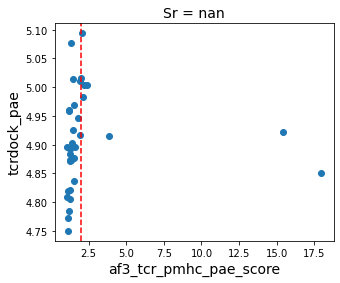

In [6]:
plt.figure(figsize=(5, 4))
plt.scatter(df_new['af3_tcr_pmhc_pae_score'], df_new['tcrdock_pae'])

plt.axvline(2, color='red', linestyle='--')

plt.xlabel('af3_tcr_pmhc_pae_score', fontsize=14)
plt.ylabel('tcrdock_pae', fontsize=14)
plt.title(f'Sr = {spearmanr(df_new["af3_tcr_pmhc_pae_score"], df_new["tcrdock_pae"])[0]:.2f}', fontsize=14)
plt.show()

In [7]:
## filter df by what's below 2 in af3_tcr_pmhc_pae_score
mask = df_new['af3_tcr_pmhc_pae_score'] < 2
df_new_filtered = df_new[mask]

'''
Sample the following rows:
    3 from (fixed_structure, hpvg)
    3 from (fixed_structure, hpvg_q5)
    5 from (sim_anneal, hpvg)
'''

# select rows that have sampling_method == fixed_structure and wt_for_design hpvg
mask = (df_new_filtered['sampling_method'] == 'fixed_structure') & (df_new_filtered['wt_for_design'] == 'hpvg')
df_fixed_structure_hpvg = df_new_filtered[mask].sample(3)

# select rows that have sampling_method == fixed_structure and wt_for_design hpvg_q5
mask = (df_new_filtered['sampling_method'] == 'fixed_structure') & (df_new_filtered['wt_for_design'] == 'hpvg_q5')
df_fixed_structure_hpvg_q5 = df_new_filtered[mask].sample(3)

# select rows that have sampling_method == sim_anneal and wt_for_design hpvg
mask = (df_new_filtered['sampling_method'] == 'sim_anneal') & (df_new_filtered['wt_for_design'] == 'hpvg')
df_sim_anneal_hpvg = df_new_filtered[mask].sample(5)

df_sampled = pd.concat([df_fixed_structure_hpvg, df_fixed_structure_hpvg_q5, df_sim_anneal_hpvg])

df_filtered = pd.read_csv('hpvg_and_hpvg_q5_peptide_designs_with_hcnn__pae_cutoff=5.1__seed=43__filtered_by_AF3.csv')

df_final = pd.concat([df_filtered, df_sampled]).reset_index()

df_final.to_csv('hpvg_and_hpvg_q5_peptide_designs_with_hcnn__pae_cutoff=5.1__seed=43__filtered_by_AF3__extra_samples_by_AF3.csv', index=False)

df_final


,index,Unnamed: 0,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_hpvg,hamming_distance_from_hpvg_q5,af3_tcr_pmhc_pae_score,af3_ranking_scores
0,0,0.0,HPVGEADYFEY,hpvg_wt,NaN,hpvg,4.901100,0,1,1.151491,0.93
1,1,1.0,HPVGQADYFEY,hpvg_q5_wt,NaN,hpvg_q5,4.817275,1,0,1.133119,0.93
2,2,2.0,HPVGNADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.868461,3,3,1.463231,0.91
3,3,3.0,MPIGHADFWEY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.788419,5,5,1.160596,0.92
4,4,4.0,MPVGRADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.905924,4,4,1.561238,0.90
...,...,...,...,...,...,...,...,...,...,...,...
91,28,NaN,FPMAFADYSEY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.896537,5,5,1.093506,0.95
92,10,NaN,FPFAYHDFTEY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.926297,7,7,1.460791,0.91
93,27,NaN,FPFAFADFSGY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.874019,7,7,1.234167,0.93
94,15,NaN,GPYAQHDYWEY,so3_convnet_base_ensemble,sim_anneal,hpvg,5.076488,6,5,1.325273,0.92


In [8]:
## remake the plots!

import matplotlib.pyplot as plt
import matplotlib.colors as cm

HPVG_SEQ = 'HPVGEADYFEY'
HPVG_Q5_SEQ = 'HPVGQADYFEY'

SEED = 43
np.random.seed(SEED)

PAE_CUTOFF = 5.1

def hamming_distance(seq1, seq2):
    assert len(seq1) == len(seq2)
    return sum([seq1[i] != seq2[i] for i in range(len(seq1))])

all_sequences = df_final['sequence'].values

sequence_sets = []
pae_sets = []
af3_sets = []

# first set is the WT
sequence_sets.append([HPVG_SEQ, HPVG_Q5_SEQ])
pae_sets.append([df_final[df_final['sequence'] == HPVG_SEQ]['tcrdock_pae'].values[0], df_final[df_final['sequence'] == HPVG_Q5_SEQ]['tcrdock_pae'].values[0]])
af3_sets.append([df_final[df_final['sequence'] == HPVG_SEQ]['af3_tcr_pmhc_pae_score'].values[0], df_final[df_final['sequence'] == HPVG_Q5_SEQ]['af3_tcr_pmhc_pae_score'].values[0]])

# mask is sampling_method fixed_structure and wt_for_design hpvg
mask = (df_final['sampling_method'] == 'fixed_structure') & (df_final['wt_for_design'] == 'hpvg')
sequence_sets.append(df_final[mask]['sequence'].values)
pae_sets.append(df_final[mask]['tcrdock_pae'].values)
af3_sets.append(df_final[mask]['af3_tcr_pmhc_pae_score'].values)

# mask is sampling_method sim_anneal and wt_for_design hpvg
mask = (df_final['sampling_method'] == 'sim_anneal') & (df_final['wt_for_design'] == 'hpvg')
sequence_sets.append(df_final[mask]['sequence'].values)
pae_sets.append(df_final[mask]['tcrdock_pae'].values)
af3_sets.append(df_final[mask]['af3_tcr_pmhc_pae_score'].values)

# mask is sampling_method fixed_structure and wt_for_design hpvg_q5
mask = (df_final['sampling_method'] == 'fixed_structure') & (df_final['wt_for_design'] == 'hpvg_q5')
sequence_sets.append(df_final[mask]['sequence'].values)
pae_sets.append(df_final[mask]['tcrdock_pae'].values)
af3_sets.append(df_final[mask]['af3_tcr_pmhc_pae_score'].values)

# mask is sampling_method sim_anneal and wt_for_design hpvg_q5
mask = (df_final['sampling_method'] == 'sim_anneal') & (df_final['wt_for_design'] == 'hpvg_q5')
sequence_sets.append(df_final[mask]['sequence'].values)
pae_sets.append(df_final[mask]['tcrdock_pae'].values)
af3_sets.append(df_final[mask]['af3_tcr_pmhc_pae_score'].values)


## plot hamming distances to WT
plt.figure(figsize=(22, 5))

tab20_colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)]
color_sets = ['black', tab20_colors[6], tab20_colors[7], tab20_colors[0], tab20_colors[1], tab20_colors[12], tab20_colors[13]]
color_names = ['Wildtype', 'HPVG Fixed Struc.', 'HPVG Sim. Anneal.', 'HPVG_Q5 Fixed Struc.' 'HPVG_Q5 Sim. Anneal.']

plt.grid(axis='y', ls='--', alpha=0.5)

start_ind = 0
for sequences, color in zip(sequence_sets,
                            color_sets):
    indices = np.arange(start_ind, start_ind+len(sequences))
    start_ind += len(sequences)

    for WT_SEQ, marker in zip([HPVG_SEQ, HPVG_Q5_SEQ],
                                ['s', '^']):
        hamming_distances = [hamming_distance(seq, WT_SEQ) for seq in sequences]
        plt.scatter(indices, hamming_distances, color=color, marker=marker)

plt.xticks(np.arange(len(all_sequences)), ['HPVG', 'HPVG_Q5'] + [f'p{i+1}' for i in range(len(all_sequences)-2)], rotation=80, fontsize=11)
plt.yticks(np.arange(10), np.arange(10), fontsize=11)

plt.ylabel('Hamming Distance\nfrom HPVG and HPVG_Q5', fontsize=14)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_handles = [Patch(edgecolor='w', facecolor=color, label=name) for color, name in zip(color_sets, color_names)]
legend_handles += [Line2D([0], [0], marker='s', color='w', label='Distance from HPVG', markerfacecolor='k', markersize=15),
                    Line2D([0], [0], marker='^', color='w', label='Distance from HPVG_Q5', markerfacecolor='k', markersize=15)]
plt.gca().legend(handles=legend_handles, loc='center right', fontsize=11, bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.savefig(f'hpvg_and_hpvg_q5_hamming_distance_of_selected_designs__pae_cutoff={PAE_CUTOFF}__seed={SEED}__filtered_by_AF3__extra_samples_by_AF3.png')
plt.close()


## plot TCRdock PAE
plt.figure(figsize=(22, 5))

tab20_colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)]
color_sets = ['black', tab20_colors[6], tab20_colors[7], tab20_colors[0], tab20_colors[1]]
color_names = ['Wildtype', 'HPVG Fixed Struc.', 'HPVG Sim. Anneal.', 'HPVG_Q5 Fixed Struc.' 'HPVG_Q5 Sim. Anneal.']

plt.grid(axis='y', ls='--', alpha=0.5)

start_ind = 0
for sequences, paes, color in zip(sequence_sets,
                                    pae_sets,
                                    color_sets):
    indices = np.arange(start_ind, start_ind+len(sequences))
    start_ind += len(sequences)

    plt.scatter(indices, -np.array(paes), color=color, marker='o')

plt.xticks(np.arange(len(all_sequences)), ['HPVG', 'HPVG_Q5'] + [f'p{i+1}' for i in range(len(all_sequences)-2)], rotation=80, fontsize=11)

plt.ylabel('Negative TCRDock PAE', fontsize=14)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_handles = [Patch(edgecolor='w', facecolor=color, label=name) for color, name in zip(color_sets, color_names)]
plt.gca().legend(handles=legend_handles, loc='center right', fontsize=11, bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.savefig(f'hpvg_and_hpvg_q5_neg_tcrdock_pae_of_selected_designs__pae_cutoff={PAE_CUTOFF}__seed={SEED}__filtered_by_AF3__extra_samples_by_AF3.png')
plt.close()


## plot AF3 PAE
plt.figure(figsize=(22, 5))

tab20_colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)]
color_sets = ['black', tab20_colors[6], tab20_colors[7], tab20_colors[0], tab20_colors[1]]
color_names = ['Wildtype', 'HPVG Fixed Struc.', 'HPVG Sim. Anneal.', 'HPVG_Q5 Fixed Struc.' 'HPVG_Q5 Sim. Anneal.']

plt.grid(axis='y', ls='--', alpha=0.5)

start_ind = 0
for sequences, paes, color in zip(sequence_sets,
                                    af3_sets,
                                    color_sets):
    indices = np.arange(start_ind, start_ind+len(sequences))
    start_ind += len(sequences)

    plt.scatter(indices, -np.array(paes), color=color, marker='o')

plt.xticks(np.arange(len(all_sequences)), ['HPVG', 'HPVG_Q5'] + [f'p{i+1}' for i in range(len(all_sequences)-2)], rotation=80, fontsize=11)

plt.ylabel('Negative AlphaFold3 PAE', fontsize=14)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_handles = [Patch(edgecolor='w', facecolor=color, label=name) for color, name in zip(color_sets, color_names)]
plt.gca().legend(handles=legend_handles, loc='center right', fontsize=11, bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.savefig(f'hpvg_and_hpvg_q5_neg_alphafold3_pae_of_selected_designs__pae_cutoff={PAE_CUTOFF}__seed={SEED}__filtered_by_AF3__extra_samples_by_AF3.png')
plt.close()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_curve, auc

df = pd.read_csv('AF3scoreAdded_EBV_GFP_results.csv', index_col=0)

# add epsilon to avoid division by zero
eps = 1e-3
df['r1'] = df['r1'] + eps
df['r2'] = df['r2'] + eps
df['r3'] = df['r3'] + eps

cutoff = df.loc['unstim', ['r1', 'r2', 'r3']].mean() + df.loc['unstim', ['r1', 'r2', 'r3']].std() * 3

print(cutoff)

# df['r1_resp'] = df['r1'] > cutoff
# df['r2_resp'] = df['r2'] > cutoff
# df['r3_resp'] = df['r3'] > cutoff

# # resp is if all resp positively
# df['Resp'] = df[['r1_resp', 'r2_resp', 'r3_resp']].all(axis=1)

df['Resp'] = [True if elem > cutoff else False for elem in df[['r1', 'r2', 'r3']].mean(axis=1)]

resp_to_color = {True: 'darkorange', False: 'mediumaquamarine'}
model_to_marker = {'hpvg_wt': 'X', 'hpvg_q5_wt': 'X', 'so3_convnet_base_ensemble__fixed_structure': 's', 'so3_convnet_noise=0p5__fixed_structure': 'd', 'so3_convnet_base_ensemble__sim_anneal': '<', 'so3_convnet_noise=0p5__sim_anneal': '>'}
models = list(model_to_marker.keys())

def get_model_mask(df, model_and_method):
    model_and_method_split = model_and_method.split('__')[0]
    if len(model_and_method.split('__')) == 1:
        return df['model'] == model_and_method
    elif len(model_and_method.split('__')) == 2:
        return (df['model'] == model_and_method.split('__')[0]) & (df['sampling_method'] == model_and_method.split('__')[1])
    else:
        raise ValueError('model_and_method must have at most one "__"')

df['min_hamming_distance_from_struc'] = np.min(df[['hamming_distances_from_hpvg', 'hamming_distance_from_hpvg_q5']], axis=1)


score_wt = df.loc[df['model'] == 'hpvg_wt', ['r1', 'r2', 'r3']].values[0]
score_wt_q5 = df.loc[df['model'] == 'hpvg_q5_wt', ['r1', 'r2', 'r3']].values[0]

# remove wildtypes, corresponding to indices values ebv_p1_wt and ebv_p2
df = df.drop(['ebv_p1_wt', 'ebv_p2'])


# remove unstim
unstim_values = df.loc['unstim'][['r1', 'r2', 'r3']].values
print(unstim_values)

unstim_values = np.array([0.311142367, 0.004291111, 0.001])

df = df.drop('unstim')

df

0.6398327818047831
[0.311142367 0.004291111 0.001]


,index,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_hpvg,hamming_distance_from_hpvg_q5,af3_tcr_pmhc_pae_score,af3_ranking_scores,r1,r2,r3,Resp,min_hamming_distance_from_struc
ebv_p3,2.0,HPVGNADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.868461,3.0,3.0,1.463231,0.91,2.543713,3.914211,3.603311,True,3.0
ebv_p4,3.0,MPIGHADFWEY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.788419,5.0,5.0,1.160596,0.92,0.006884,0.012130,0.001000,False,5.0
ebv_p5,4.0,MPVGRADYWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.905924,4.0,4.0,1.561238,0.90,0.024636,0.001000,0.013726,False,4.0
ebv_p6,5.0,HPMGMADHWMY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.941916,5.0,5.0,1.182298,0.93,0.023938,0.042408,0.025454,False,5.0
ebv_p7,6.0,HPVGRADFWQY,so3_convnet_base_ensemble,fixed_structure,hpvg,4.992226,4.0,4.0,1.409040,0.90,0.003812,0.060240,0.013626,False,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ebv_p91,36.0,MPLGQADFWEF,so3_convnet_base_ensemble,fixed_structure,hpvg_q5,4.784465,6.0,5.0,1.179768,0.92,0.355124,0.290279,0.234749,False,5.0
ebv_p92,10.0,FPFAYHDFTEY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.926297,7.0,7.0,1.460791,0.91,0.020228,0.013566,0.008599,False,7.0
ebv_p93,13.0,HALGQGDEWTY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.870895,7.0,6.0,1.234344,0.92,0.024955,0.008739,0.035447,False,6.0
ebv_p94,28.0,FPMAFADYSEY,so3_convnet_base_ensemble,sim_anneal,hpvg,4.896537,5.0,5.0,1.093506,0.95,48.810874,51.598206,53.824573,True,5.0


/tmp/ipykernel_544044/711882832.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['$10^{}$'.format('{' + str(int(y)) + '}') for y in ax.get_yticks()])


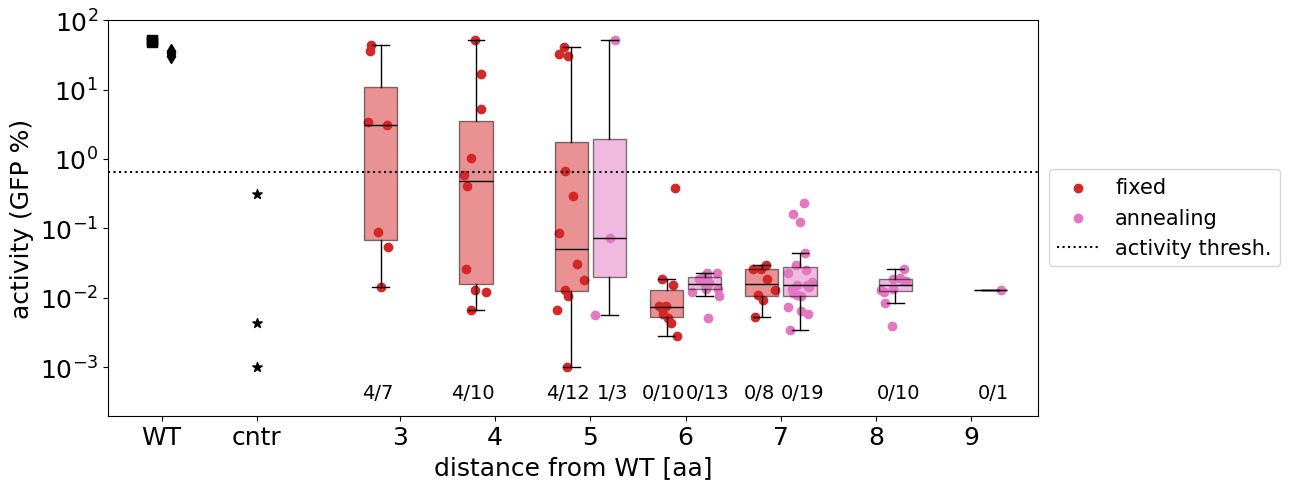

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fontsize = 18

# make a barplot of success over distance from wildtype for the 4 model classes
model_groups = [('so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure'), ('so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal')]
model_group_names = ['fixed', 'annealing']
colors = ['tab:red', 'tab:pink']

plt.figure(figsize=(13, 5))
ax = plt.gca()

df_here = df.loc[df['tcrdock_pae'] < 5.5]

all_distances = sorted(np.unique(df_here['min_hamming_distance_from_struc'].values))

for i, (model_group, model_group_name, color) in enumerate(zip(model_groups, model_group_names, colors)):
    mask1 = get_model_mask(df, model_group[0])
    mask2 = get_model_mask(df, model_group[1])
    mask = np.logical_or(mask1, mask2)
    curr_df = df_here[mask]
    distances = curr_df['min_hamming_distance_from_struc'].values
    responses = curr_df['Resp'].values

    distance_to_resp = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
        
    distance_to_exp_score = {}
    distance_to_min_exp_score = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_exp_score[distance] = np.vstack([curr_df[dist_mask]['r1'],
                                                                  curr_df[dist_mask]['r2'],
                                                                  curr_df[dist_mask]['r3']])
        distance_to_min_exp_score[distance] = np.mean(distance_to_exp_score[distance], axis=0)
    
    distances = list(distance_to_exp_score.keys())
    scores = [np.log10(distance_to_exp_score[distance]) for distance in distances]
    min_scores = [np.log10(distance_to_min_exp_score[distance]) for distance in distances]

    positions = [distance - 0.2 + i*0.4 for distance in distances]

    ax.boxplot(min_scores, positions=positions, showfliers=False, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.5), medianprops=dict(color="black", linewidth=1))

    k = 0
    for position, scores_in_distance in zip(positions, min_scores):
        if len(scores_in_distance.shape) == 2:
            scores_in_distance = scores_in_distance.T
        for item in scores_in_distance:
            noise = np.random.uniform(-0.15, 0.15)
            len_item = len(item) if isinstance(item, np.ndarray) else 1
            if k == 0:
                ax.scatter([position+noise]*len_item, item, color=color, label=model_group_name)
                # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
            else:
                ax.scatter([position+noise]*len_item, item, color=color)
                # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
            k += 1

    # put number of examples under each boxplot
    ax.set_ylim(-3.7, 2)
    for position, distance, scores_in_distance in zip(positions, distances, min_scores):
        offset = 0.03 if i == 1 else -0.03
        ax.text(position+offset, -3.5, f'{int(distance_to_resp[distance][True])}/{len(scores_in_distance)}', ha='center', va='bottom', fontsize=fontsize-4)


min_distance = min(all_distances)
wt_xtick = min_distance - 2.5
control_xtick = wt_xtick + 1

ax.scatter([wt_xtick-0.1]*len(score_wt), np.log10(score_wt), color='black', marker='s', s=50)
ax.scatter([wt_xtick+0.1]*len(score_wt_q5), np.log10(score_wt_q5), color='black', marker='d', s=50)
ax.scatter([control_xtick]*len(unstim_values), np.log10(unstim_values), color='black', marker='*', s=50)

ax.axhline(np.log10(cutoff), color='black', linestyle=':', label='activity thresh.')

xticks = [wt_xtick, control_xtick] + list(all_distances)
xticklabels = ['WT', 'cntr'] + [str(int(distance)) for distance in all_distances]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_yticklabels(['$10^{}$'.format('{' + str(int(y)) + '}') for y in ax.get_yticks()])

ax.tick_params(axis='both', labelsize=fontsize)


ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
ax.set_ylabel('activity (GFP %)', fontsize=fontsize)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# put legend outside of figure on the right
ax.legend(fontsize=fontsize-3, bbox_to_anchor=(1, 0.65))

plt.tight_layout()
plt.savefig('__pretty_ebv_mean_exp_scores_vs_hamming_distance_from_wt.png')
plt.savefig('__pretty_ebv_mean_exp_scores_vs_hamming_distance_from_wt.pdf')
plt.show()

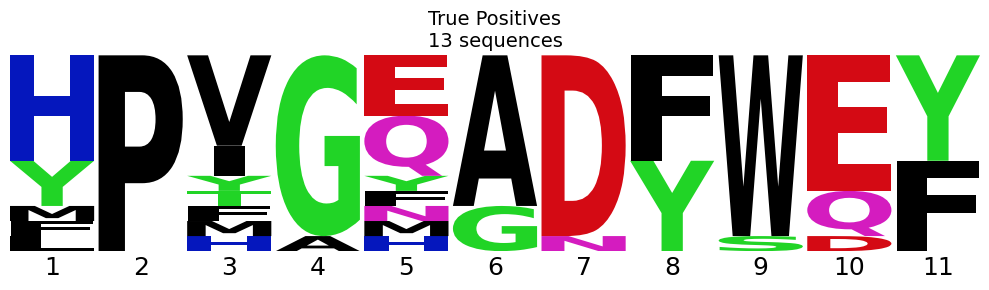

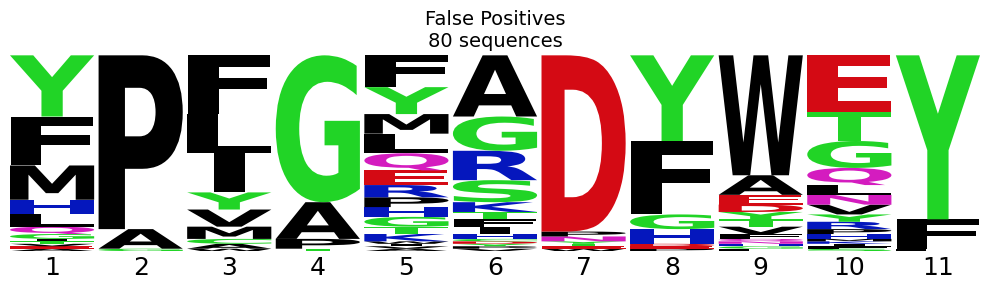

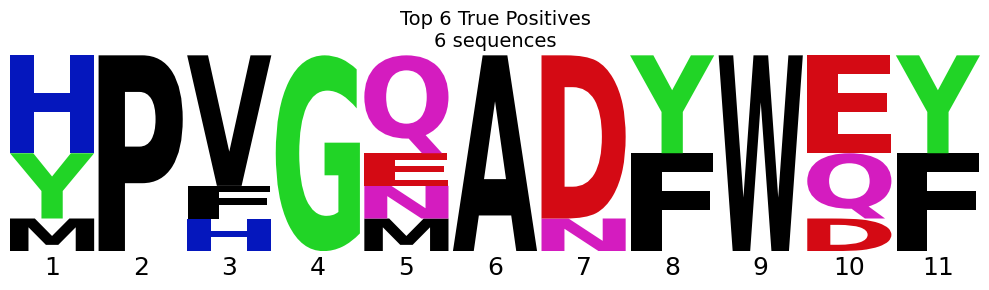

In [5]:
# 4 logoplots: true and tcrdock pae below 5.5; false and tcrdock pae below 5.5; flase and tcrdock pae above 5.5; false and tcrdock pae above 5.5
# write the number of sequences in each logoplot

AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
import logomaker

# true and tcrdock pae below 5.5
df_true_below = df[(df['tcrdock_pae'] < 5.5) & (df['Resp'] == True)]
df_false_below = df[(df['tcrdock_pae'] < 5.5) & (df['Resp'] == False)]

len_seq = len(df_true_below['sequence'].values[0])

for title, df_ in zip(['True Positives', 'False Positives'],
                      [df_true_below, df_false_below]):

    plt.figure(figsize=(10, 3))

    # get sequences, make pwm
    seqs = df_['sequence']
    pwm = np.zeros((len_seq, len(AMINO_ACIDS)))
    for seq in seqs:
        assert len(seq) == len_seq
        for i, aa in enumerate(seq):
            pwm[i, AMINO_ACIDS.index(aa)] += 1
    pwm = pwm / pwm.sum(axis=1)[:, None]
    pwm[np.isnan(pwm)] = 0

    # plot pwm as logoplot
    df_pwm = pd.DataFrame(pwm, columns=AMINO_ACIDS)
    logomaker.Logo(df_pwm, ax=plt.gca())

    plt.title(title + f'\n{len(seqs)} sequences', fontsize=14)

    plt.xticks(np.arange(len_seq), np.arange(len_seq)+1)

    # keep x axis labels, but nothing else pertaiing to the axis
    
    # Hide the y-axis completely
    plt.gca().get_yaxis().set_visible(False)

    # Remove the x-axis horizontal line (spine)
    plt.gca().spines['bottom'].set_visible(False)

    # Remove all the spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Remove y-ticks
    plt.gca().tick_params(axis='y', which='both', length=0)

    # Remove x-tick marks but keep the labels
    plt.gca().tick_params(axis='x', which='both', length=0)

    plt.gca().tick_params(axis='x', labelsize=18)

    plt.tight_layout()
    plt.savefig(f'__pretty_ebv_{title.replace(" ", "_").lower()}_logoplot.pdf')
    plt.savefig(f'__pretty_ebv_{title.replace(" ", "_").lower()}_logoplot.png')
    plt.show()


# top k peptides
df_ = df[(df['tcrdock_pae'] < 5.5) & (df['Resp'] == True)]

# only keep the k lowest mean r1	r2	r3 values
k = 6
df_ = df_.sort_values(['r1', 'r2', 'r3']).head(k)

title = f'Top {k} True Positives'

plt.figure(figsize=(10, 3))

# get sequences, make pwm
seqs = df_['sequence']
pwm = np.zeros((len_seq, len(AMINO_ACIDS)))
for seq in seqs:
    assert len(seq) == len_seq
    for i, aa in enumerate(seq):
        pwm[i, AMINO_ACIDS.index(aa)] += 1
pwm = pwm / pwm.sum(axis=1)[:, None]
pwm[np.isnan(pwm)] = 0

# plot pwm as logoplot
df_pwm = pd.DataFrame(pwm, columns=AMINO_ACIDS)
logomaker.Logo(df_pwm, ax=plt.gca())

plt.title(title + f'\n{len(seqs)} sequences', fontsize=14)

plt.xticks(np.arange(len_seq), np.arange(len_seq)+1)

# keep x axis labels, but nothing else pertaiing to the axis

# Hide the y-axis completely
plt.gca().get_yaxis().set_visible(False)

# Remove the x-axis horizontal line (spine)
plt.gca().spines['bottom'].set_visible(False)

# Remove all the spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove y-ticks
plt.gca().tick_params(axis='y', which='both', length=0)

# Remove x-tick marks but keep the labels
plt.gca().tick_params(axis='x', which='both', length=0)

plt.gca().tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.savefig(f'__pretty_ebv_{title.replace(" ", "_").lower()}_logoplot.pdf')
plt.savefig(f'__pretty_ebv_{title.replace(" ", "_").lower()}_logoplot.png')
plt.show()

# HPVGEADYFEY

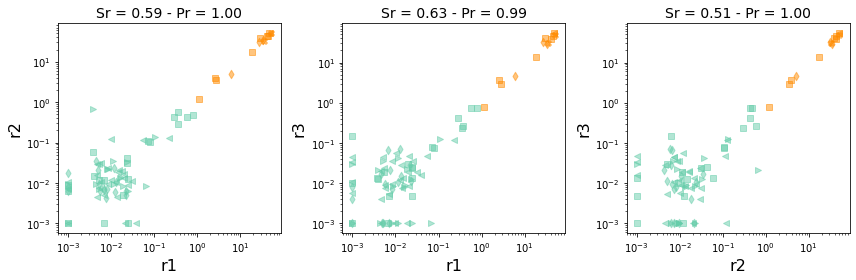

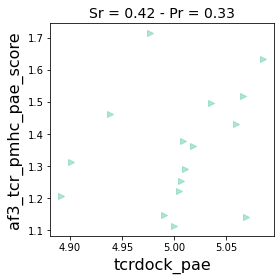

In [2]:
## plot replicates against each other

ncols = 3
nrows = 1
colsize = 4
rowsize = 4
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows)

colors = {True: 'darkorange', False: 'mediumaquamarine'}

replicates_columns = ['r1', 'r2', 'r3']


# replicates against each other
for col, (rep1, rep2) in enumerate([(rep1, rep2) for i, rep1 in enumerate(replicates_columns) for rep2 in replicates_columns[i+1:] if rep1 != rep2]):
    ax = axs[col]
    for response in [False, True]:
        for model in models:
            mask = np.logical_and(get_model_mask(df, model), df['Resp'] == response)
            ax.scatter(df[mask][rep1], df[mask][rep2], marker=model_to_marker[model], c=resp_to_color[response], alpha=0.5)
    # ax.scatter(df[rep1], df[rep2], c='blue', alpha=0.5)
    ax.set_title('Sr = %.2f - Pr = %.2f' % (spearmanr(df[rep1], df[rep2])[0], pearsonr(df[rep1], df[rep2])[0]), fontsize=14)
    ax.set_xlabel(rep1, fontsize=16)
    ax.set_ylabel(rep2, fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

## plot tcrdock_pae against af3_tcr_pmhc_pae_score

plt.figure(figsize=(4, 4))
for response in [False, True]:
    mask = np.logical_and(get_model_mask(df, model), df['Resp'] == response)
    mask = np.logical_and(mask, ~np.isnan(df['af3_tcr_pmhc_pae_score']))
    plt.scatter(df[mask]['tcrdock_pae'], df[mask]['af3_tcr_pmhc_pae_score'], marker=model_to_marker[model], c=colors[response], alpha=0.5)
# plt.scatter(df['tcrdock_pae'], df['af3_tcr_pmhc_pae_score'], c='blue', alpha=0.5)
plt.title('Sr = %.2f - Pr = %.2f' % (spearmanr(df['tcrdock_pae'][~np.isnan(df['af3_tcr_pmhc_pae_score'])], df['af3_tcr_pmhc_pae_score'][~np.isnan(df['af3_tcr_pmhc_pae_score'])])[0], pearsonr(df['tcrdock_pae'][~np.isnan(df['af3_tcr_pmhc_pae_score'])], df['af3_tcr_pmhc_pae_score'][~np.isnan(df['af3_tcr_pmhc_pae_score'])])[0]), fontsize=14)
plt.xlabel('tcrdock_pae', fontsize=16)
plt.ylabel('af3_tcr_pmhc_pae_score', fontsize=16)
plt.tight_layout()
plt.show()

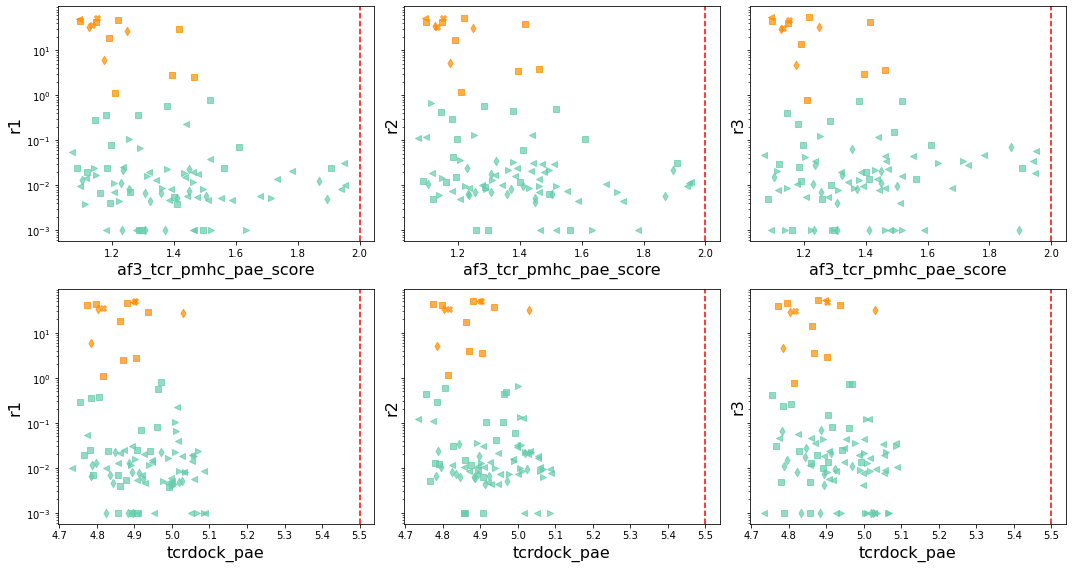

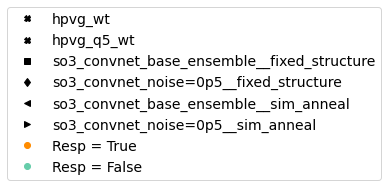

In [3]:
predictors = ['af3_tcr_pmhc_pae_score', 'tcrdock_pae']
measurements = ['r1', 'r2', 'r3']

predictor_to_cutoff = {'af3_tcr_pmhc_pae_score': 2.0, 'tcrdock_pae': 5.5}

ncols = len(measurements)
nrows = len(predictors)
colsize = 5
rowsize = 4
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharey=True)

for row, predictor in enumerate(predictors):
    for col, measurement in enumerate(measurements):
        ax = axs[row, col]
        for response in [False, True]:
            for model in models:
                mask = np.logical_and(get_model_mask(df, model), df['Resp'] == response)
                ax.scatter(df[mask][predictor], df[mask][measurement], marker=model_to_marker[model], c=resp_to_color[response], alpha=0.7, label=response)
        # ax.scatter(df[predictor], df[measurement], c='blue', alpha=0.5)
        ax.axvline(predictor_to_cutoff[predictor], color='red', linestyle='--')
        ax.set_yscale('log')
        ax.set_xlabel(predictor, fontsize=16)
        ax.set_ylabel(measurement, fontsize=16)
        # ax.legend(fontsize=14)

plt.tight_layout()
plt.show()

# make legend with right colors, put it in its own figure
plt.figure(figsize=(2, 2))
plt.axis('off')
legend_handles = [plt.Line2D([0], [0], marker=model_to_marker[model], ls='', color='black', label=model, markerfacecolor='black') for model in models]
legend_handles += [plt.Line2D([0], [0], marker='o', ls='', color=color, label=f'Resp = {resp}', markerfacecolor=color) for resp, color in resp_to_color.items()]
plt.gca().legend(handles=legend_handles, loc='center', fontsize=14)
plt.show()

<Figure size 432x288 with 0 Axes>

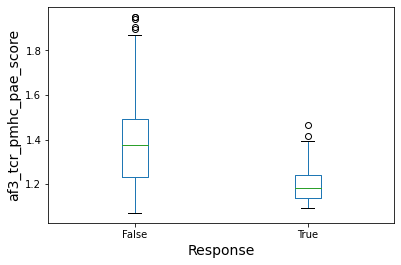

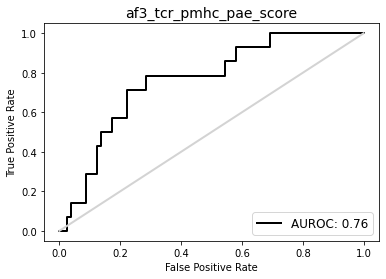

<Figure size 432x288 with 0 Axes>

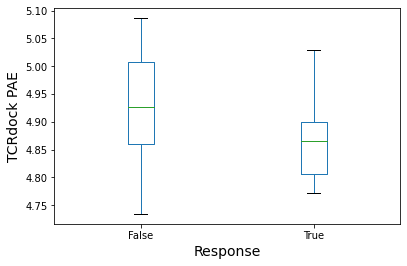

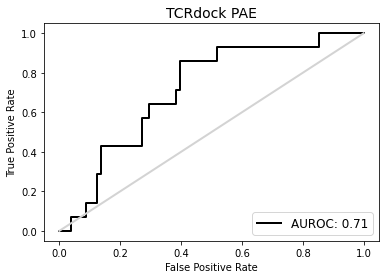

In [4]:
## replicate Asya's plots, to make sure stuff is right

# boxplot with af3_ranking_scores on y axis, True or False on x axis based on Resp
plt.figure(figsize=(6, 4))
df.boxplot(column='af3_tcr_pmhc_pae_score', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('af3_tcr_pmhc_pae_score', fontsize=14)
plt.show()

# roc curve plot and auroc for tcrdock_pae
mask = ~df['af3_tcr_pmhc_pae_score'].isna()
fpr, tpr, _ = roc_curve(df['Resp'][mask], -df['af3_tcr_pmhc_pae_score'][mask])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('af3_tcr_pmhc_pae_score', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()


# boxplot with tcrdock_pae on y axis, True or False on x axis based on Resp
plt.figure(figsize=(6, 4))
df.boxplot(column='tcrdock_pae', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('TCRdock PAE', fontsize=14)
plt.show()

# roc curve plot and auroc for tcrdock_pae
fpr, tpr, _ = roc_curve(df['Resp'], -df['tcrdock_pae'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TCRdock PAE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()


# # boxplot with blosum_full on y axis, True or False on x axis based on Resp
# plt.figure(figsize=(6, 4))
# df.boxplot(column='blosum_full', by='Resp', grid=False)
# plt.title('')
# plt.suptitle('')
# plt.xlabel('Response', fontsize=14)
# plt.ylabel('BLOSUM62 Full Peptide', fontsize=14)
# plt.show()

# # roc curve plot and auroc for blosum_full
# fpr, tpr, _ = roc_curve(df['Resp'], df['blosum_full'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
# plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('BLOSUM62 Full Peptide', fontsize=14)
# plt.legend(loc='lower right', fontsize=12)
# plt.show()


# # boxplot with blosum_diff on y axis, True or False on x axis based on Resp
# plt.figure(figsize=(6, 4))
# df.boxplot(column='blosum_diff', by='Resp', grid=False)
# plt.title('')
# plt.suptitle('')
# plt.xlabel('Response', fontsize=14)
# plt.ylabel('BLOSUM62 Diff from WT', fontsize=14)
# plt.show()

# # roc curve plot and auroc for blosum_diff
# fpr, tpr, _ = roc_curve(df['Resp'], df['blosum_diff'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
# plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('BLOSUM62 Diff from WT', fontsize=14)
# plt.legend(loc='lower right', fontsize=12)
# plt.show()

<Figure size 432x288 with 0 Axes>

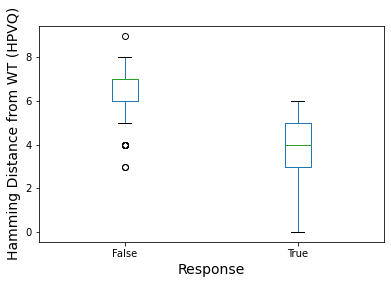

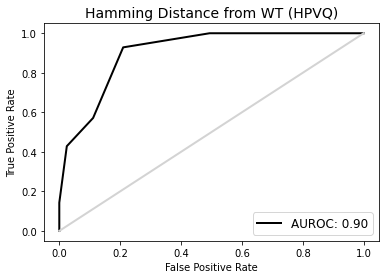

<Figure size 432x288 with 0 Axes>

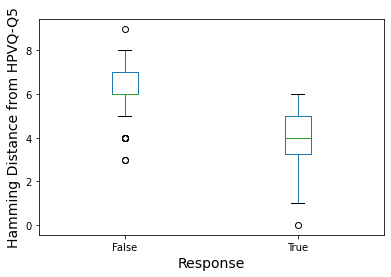

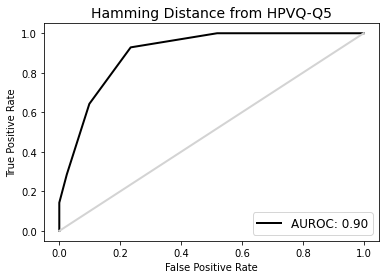

<Figure size 432x288 with 0 Axes>

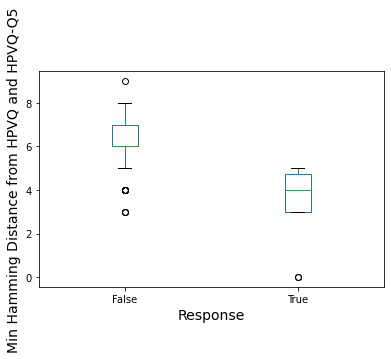

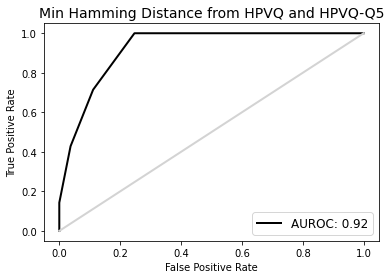

In [5]:
# boxplot
plt.figure(figsize=(6, 4))
df.boxplot(column='hamming_distances_from_hpvg', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('Hamming Distance from WT (HPVQ)', fontsize=14)
plt.show()

# roc curve plot and auroc for combined score
fpr, tpr, _ = roc_curve(df['Resp'], -df['hamming_distances_from_hpvg'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hamming Distance from WT (HPVQ)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()



# boxplot
plt.figure(figsize=(6, 4))
df.boxplot(column='hamming_distance_from_hpvg_q5', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('Hamming Distance from HPVQ-Q5', fontsize=14)
plt.show()

# roc curve plot and auroc for combined score
fpr, tpr, _ = roc_curve(df['Resp'], -df['hamming_distance_from_hpvg_q5'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hamming Distance from HPVQ-Q5', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()



# boxplot
plt.figure(figsize=(6, 4))
df.boxplot(column='min_hamming_distance_from_struc', by='Resp', grid=False)
plt.title('')
plt.suptitle('')
plt.xlabel('Response', fontsize=14)
plt.ylabel('Min Hamming Distance from HPVQ and HPVQ-Q5', fontsize=14)
plt.show()

# roc curve plot and auroc for combined score
fpr, tpr, _ = roc_curve(df['Resp'], -df['min_hamming_distance_from_struc'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Min Hamming Distance from HPVQ and HPVQ-Q5', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()

In [6]:
# print number of good respondes per model and sampling method
results = {}
for model in models:
    mask = get_model_mask(df, model)
    results[model] = {'num_resp': df[mask]['Resp'].sum(), 'total': len(df[mask])}

for model in models:
    print(f'{model}: {results[model]["num_resp"]}/{results[model]["total"]} - {int((results[model]["num_resp"]/results[model]["total"])*100)}%')

hpvg_wt: 1/1 - 100%
hpvg_q5_wt: 1/1 - 100%
so3_convnet_base_ensemble__fixed_structure: 8/28 - 28%
so3_convnet_noise=0p5__fixed_structure: 3/19 - 15%
so3_convnet_base_ensemble__sim_anneal: 1/30 - 3%
so3_convnet_noise=0p5__sim_anneal: 0/16 - 0%


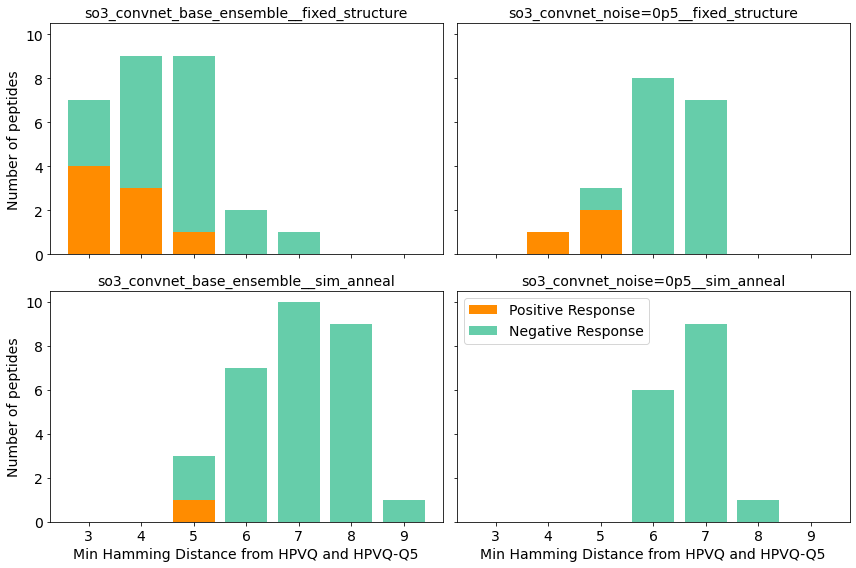

In [7]:
# make a barplot of success over distance from wildtype for the 4 model classes
models_of_interest = ['so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure', 'so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal']

ncols = 2
nrows = 2
colsize = 6
rowsize = 4
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=True, sharey=True)

for i, (ax, model) in enumerate(zip(axs.flatten(), models_of_interest)):
    mask = get_model_mask(df, model)
    curr_df = df[mask]
    distances = curr_df['min_hamming_distance_from_struc'].values
    responses = curr_df['Resp'].values

    # barplot with distance on x axis, and on y axis positive resp in one color, negative resp in another color
    distance_to_resp = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
    
    distances = list(distance_to_resp.keys())
    pos_responses = [distance_to_resp[distance][True] for distance in distances]
    neg_responses = [distance_to_resp[distance][False] for distance in distances]

    row = i // ncols
    col = i % ncols

    ax.bar(distances, pos_responses, color=resp_to_color[True])
    ax.bar(distances, neg_responses, bottom=pos_responses, color=resp_to_color[False])
    ax.set_title(model, fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    if row == nrows-1: ax.set_xlabel('Min Hamming Distance from HPVQ and HPVQ-Q5', fontsize=14)
    if col == 0: ax.set_ylabel('Number of peptides', fontsize=14)

    if row == nrows-1 and col == ncols-1:
        ax.legend(['Positive Response', 'Negative Response'], fontsize=14)

plt.tight_layout()
plt.savefig('ebv_hits_vs_hamming_distance_from_wt.png')
plt.savefig('ebv_hits_vs_hamming_distance_from_wt.pdf')
plt.show()

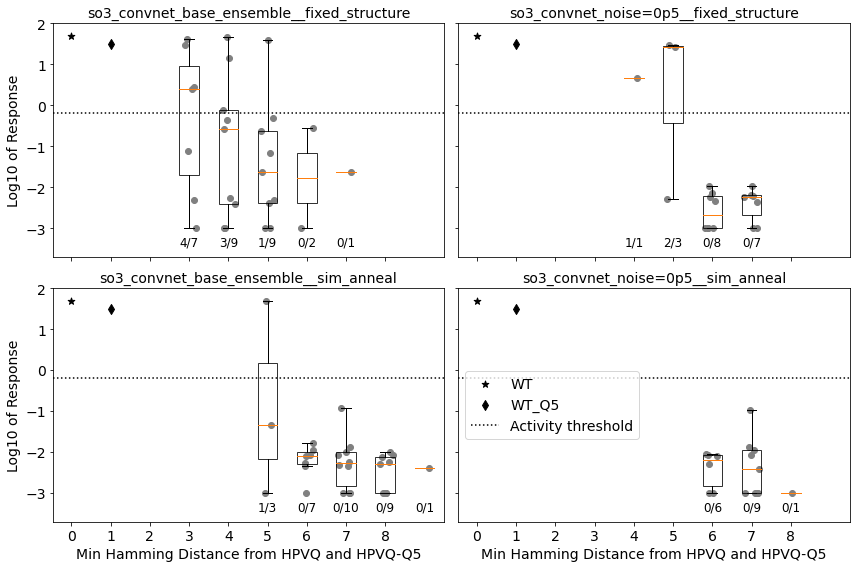

In [8]:
import seaborn as sns

# make a barplot of success over distance from wildtype for the 4 model classes
models_of_interest = ['so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure', 'so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal']

ncols = 2
nrows = 2
colsize = 6
rowsize = 4
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=True, sharey=True)

for i, (ax, model) in enumerate(zip(axs.flatten(), models_of_interest)):
    mask = get_model_mask(df, model)
    curr_df = df[mask]
    distances = curr_df['min_hamming_distance_from_struc'].values
    responses = curr_df['Resp'].values

    distance_to_resp = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
    distance_to_mean_exp_score = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_mean_exp_score[distance] = np.min(np.vstack([curr_df[dist_mask]['r1'],
                                                                  curr_df[dist_mask]['r2'],
                                                                  curr_df[dist_mask]['r3']]), axis=0)
    
    
    distances = list(distance_to_mean_exp_score.keys())
    mean_scores = [np.log10(distance_to_mean_exp_score[distance]) for distance in distances]
    # pos_responses = [distance_to_resp[distance][True] for distance in distances]
    # neg_responses = [distance_to_resp[distance][False] for distance in distances]

    row = i // ncols
    col = i % ncols

    for distance, mean_scores_in_distance in zip(distances, mean_scores):
        for item in mean_scores_in_distance:
            noise = np.random.uniform(-0.2, 0.2)
            ax.scatter([distance+noise], item, color='grey')
    # make boxplot transparent
    ax.boxplot(mean_scores, positions=distances, showfliers=False, widths=0.5, patch_artist=True, boxprops=dict(facecolor='none', alpha=0.8))

    ax.set_xticks(np.arange(max(distances)+1))
    ax.set_xticklabels([str(int(distance)) for distance in np.arange(max(distances)+1)])

    # data = dict(zip(distances, mean_scores))
    # sns.boxplot(data=data, color='lightgray', width=0.6, showfliers=False, ax=ax)
    # sns.stripplot(data=data, color='black', alpha=0.7, jitter=True, ax=ax)

    ax.scatter(0, np.log10(score_wt), color='black', marker='*', s=50, label='WT')
    ax.scatter(1, np.log10(score_wt_q5), color='black', marker='d', s=50, label='WT_Q5')
    ax.axhline(np.log10(cutoff), color='black', linestyle=':', label='Activity threshold')

    # ax.bar(distances, pos_responses, color=resp_to_color[True])
    # ax.bar(distances, neg_responses, bottom=pos_responses, color=resp_to_color[False])

    ax.set_title(model, fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    if row == nrows-1: ax.set_xlabel('Min Hamming Distance from HPVQ and HPVQ-Q5', fontsize=14)
    if col == 0: ax.set_ylabel('Log10 of Response', fontsize=14)

    # put number of examples under each boxplot
    ax.set_ylim(-3.7, 2)
    for distance, mean_scores_in_distance in zip(distances, mean_scores):
        median = np.median(mean_scores_in_distance)
        ax.text(distance, -3.5, f'{int(distance_to_resp[distance][True])}/{len(mean_scores_in_distance)}', ha='center', va='bottom', fontsize=12)

    if row == nrows-1 and col == ncols-1:
        ax.legend(fontsize=14, loc='center left')

plt.tight_layout()
plt.savefig('ebv_min_exp_scores_vs_hamming_distance_from_wt.png')
plt.savefig('ebv_min_exp_scores_vs_hamming_distance_from_wt.pdf')
plt.show()

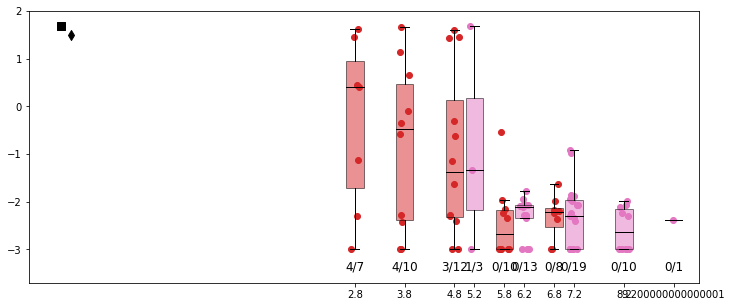

In [11]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# make a barplot of success over distance from wildtype for the 4 model classes
model_groups = [('so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure'), ('so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal')]
model_group_names = ['Fixed PWM', 'Simulated Annealing']
colors = ['tab:red', 'tab:pink']

plt.figure(figsize=(12, 5))
ax = plt.gca()

df_here = df.loc[df['tcrdock_pae'] < 5.5]

all_distances = sorted(np.unique(df_here['min_hamming_distance_from_struc'].values))

for i, (model_group, model_group_name, color) in enumerate(zip(model_groups, model_group_names, colors)):
    mask1 = get_model_mask(df, model_group[0])
    mask2 = get_model_mask(df, model_group[1])
    mask = np.logical_or(mask1, mask2)
    curr_df = df_here[mask]
    distances = curr_df['min_hamming_distance_from_struc'].values
    responses = curr_df['Resp'].values

    distance_to_resp = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
    
    distance_to_mean_exp_score = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_mean_exp_score[distance] = np.min(np.vstack([curr_df[dist_mask]['r1'],
                                                                  curr_df[dist_mask]['r2'],
                                                                  curr_df[dist_mask]['r3']]), axis=0)
    
    distances = list(distance_to_mean_exp_score.keys())
    mean_scores = [np.log10(distance_to_mean_exp_score[distance]) for distance in distances]

    positions = [distance - 0.2 + i*0.4 for distance in distances]

    ax.boxplot(mean_scores, positions=positions, showfliers=False, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.5), medianprops=dict(color="black", linewidth=1))

    k = 0
    for position, mean_scores_in_distance in zip(positions, mean_scores):
        for item in mean_scores_in_distance:
            noise = np.random.uniform(-0.1, 0.1)
            if k == 0:
                ax.scatter([position+noise], item, color=color, label=model_group_name)
            else:
                ax.scatter([position+noise], item, color=color)
            k += 1

    # put number of examples under each boxplot
    ax.set_ylim(-3.7, 2)
    for position, distance, mean_scores_in_distance in zip(positions, distances, mean_scores):
        median = np.median(mean_scores_in_distance)
        ax.text(position, -3.5, f'{int(distance_to_resp[distance][True])}/{len(mean_scores_in_distance)}', ha='center', va='bottom', fontsize=12)

min_distance = min(all_distances)
wt_xtick = min_distance - 3
control_xtick = wt_xtick + 1

ax.scatter(wt_xtick-0.1, np.log10(score_wt), color='black', marker='s', s=50)
ax.scatter(wt_xtick+0.1, np.log10(score_wt_q5), color='black', marker='d', s=50)
print(np.log(np.array(unstim_values)))
# ax.scatter([control_xtick]*len(unstim_values), np.log10(unstim_values), color='black', marker='*')
ax.axhline(np.log10(cutoff), color='black', linestyle=':', label='Activity threshold')

xticks = [wt_xtick, control_xtick] + list(all_distances)
xticklabels = ['WT', 'Control'] + [str(int(distance)) for distance in all_distances]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_yticklabels(['$10^{}$'.format('{' + str(int(y)) + '}') for y in ax.get_yticks()])


ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('Distance from WT [aa]', fontsize=14)
ax.set_ylabel('Activity', fontsize=14)


# put legend outside of figure on the right
ax.legend(fontsize=14, bbox_to_anchor=(1, 0.65))

plt.tight_layout()
plt.savefig('__pretty_ebv_min_exp_scores_vs_hamming_distance_from_wt.png')
plt.savefig('__pretty_ebv_min_exp_scores_vs_hamming_distance_from_wt.pdf')
plt.show()